In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random

In [3]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [50]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


train_input = torch.tensor(imgs).permute(0,3,1,2)
train_target = torch.tensor(gt_imgs).reshape(-1,1,400,400)

train_target[train_target > 0.5] = 1
train_target[train_target < 0.5] = -1
#train_target = train_target.long()

Loading 20 images
satImage_052.png
Loading 20 images
satImage_052.png


In [51]:
# Loaded a set of images
root_dir = "test_set_images/"

files = os.listdir(root_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
test_imgs = [load_image(root_dir + files[i] + "/" + files[i] + ".png") for i in range(n)]
print(files[0])
test = torch.tensor(test_imgs).permute(0,3,1,2)

Loading 20 images
test_13


Image size = 400,400


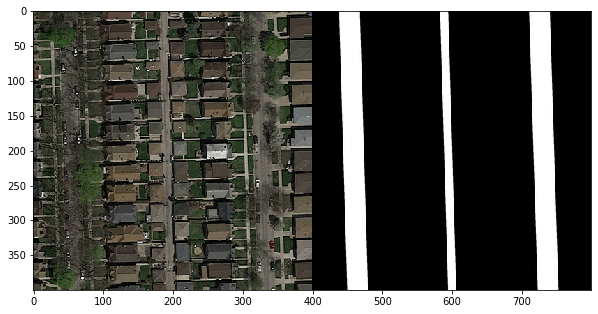

In [6]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [47]:
class Basic_Net(nn.Module):
    def __init__(self):
        super(Basic_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=32, stride=8)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 45*45, 2500)
        #self.fc2 = nn.Linear(10000, 2500)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(-1, 64* 45*45)))
        x = torch.sigmoid(x)
        x = F.interpolate(x.view(-1, 1,50,50), scale_factor=8)
        return x.view(-1, 1,400,400)

In [48]:
def train_model(model, input, target, eta):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = eta)
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, target)
    sum_loss = loss.item()

    loss.backward()
    optimizer.step()

    return sum_loss

def compute_error(model, input, target):
    output = model(input)
    output[output > 0] = 1
    output[output < 0] = -1
    errors = output != target
    frac_errors = errors.sum().item() / (target.shape[0] * target.shape[2] * target.shape[3])

    return frac_errors

def eval_model(model, train_input,train_target,eta,nb_epochs):
    print(model)
    print("TRAINING")
    print("EPOCH : TOT_LOSS : ERROR RATE")
    for e in range(0, nb_epochs):
        index = random.randrange(0,train_input.shape[0])
        sum_loss = train_model(model, train_input[index][np.newaxis,:], train_target[index][np.newaxis,:], eta)
        frac_err = compute_error(model, train_input, train_target)
        print("{:5} {:>10.4f} {:11.4f}%".format(e, sum_loss, 100 * frac_err))
    print()

In [56]:
#Metaparameters
eta = 0.1
nb_epochs = 20
model = Basic_Net()

eval_model(model, train_input, train_target, eta, nb_epochs)

Basic_Net(
  (conv1): Conv2d(3, 32, kernel_size=(32, 32), stride=(8, 8))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=129600, out_features=2500, bias=True)
)
TRAINING
EPOCH : TOT_LOSS : ERROR RATE
    0     1.9916     83.4437%
    1     2.4846     83.4437%
    2     2.0630     83.4437%
    3     2.2465     83.4437%
    4     2.1260     83.4437%
    5     2.1352     83.4437%
    6     2.4870     83.4437%
    7     2.6692     83.4437%
    8     2.3701     83.4437%
    9     2.2726     83.4437%
   10     2.4637     83.4437%
   11     2.2852     83.4437%
   12     2.2542     83.4437%
   13     2.2228     83.4437%
   14     2.0888     83.4437%
   15     2.6408     83.4437%
   16     2.6378     83.4437%
   17     2.2058     83.4437%
   18     2.1756     83.4437%
   19     2.0861     83.4437%



In [54]:
def visualize(idx):
    prediction = model(train_input[idx].reshape(1,3,400,400))
    prediction = prediction.detach().numpy().reshape(400,400)
    #prediction[prediction > 0] = 0
    #prediction[prediction > 0] = 1
    #prediction = 1 - prediction
    cimg = concatenate_images(imgs[idx],prediction)
    cimg = concatenate_images(cimg,gt_imgs[idx])
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

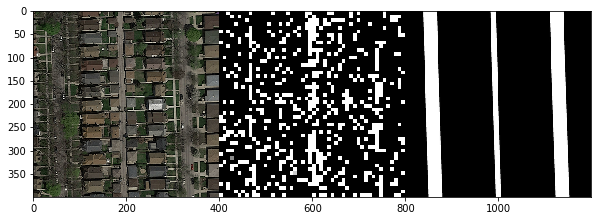

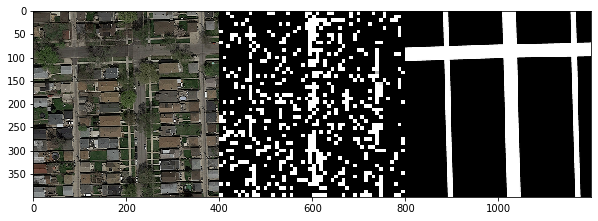

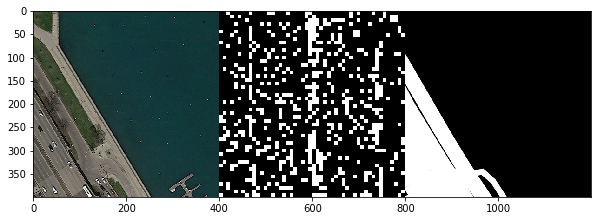

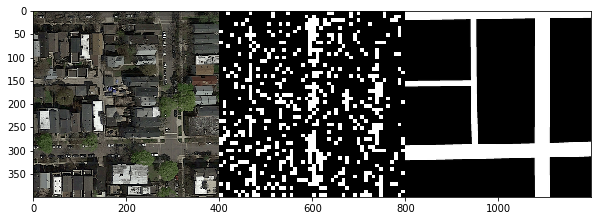

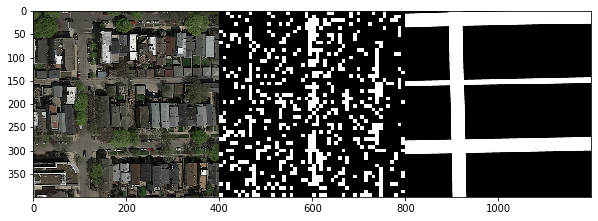

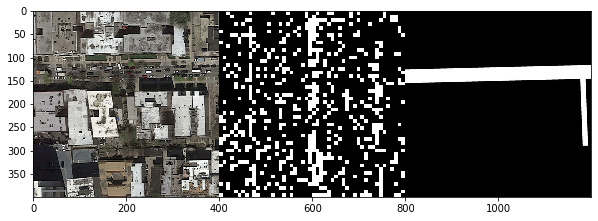

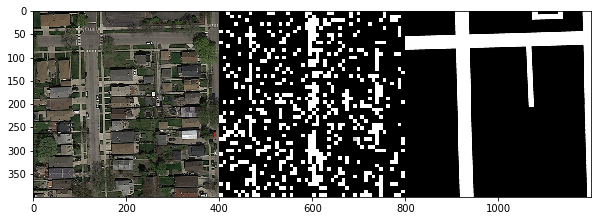

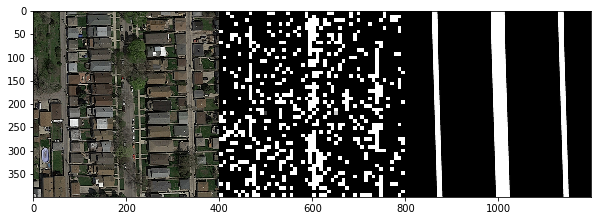

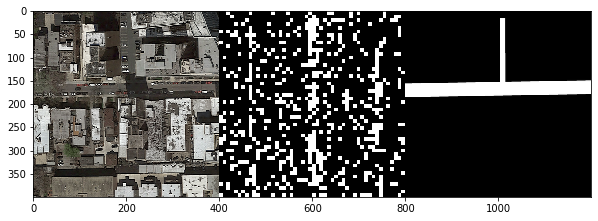

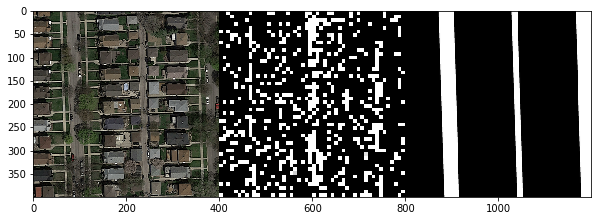

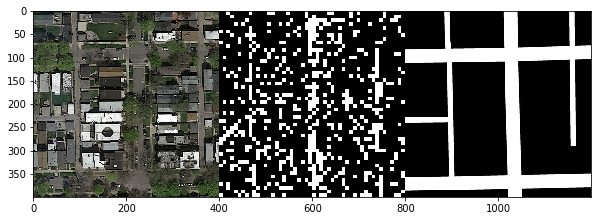

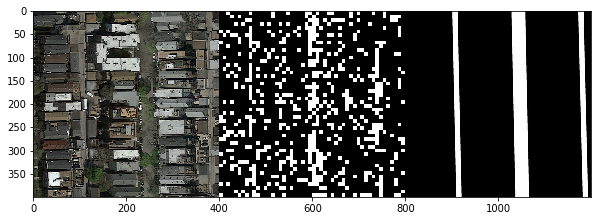

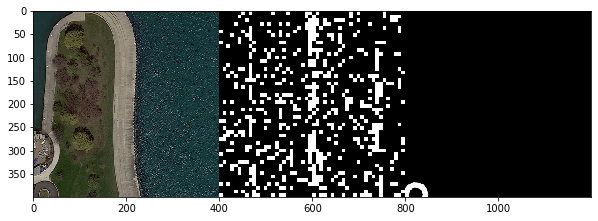

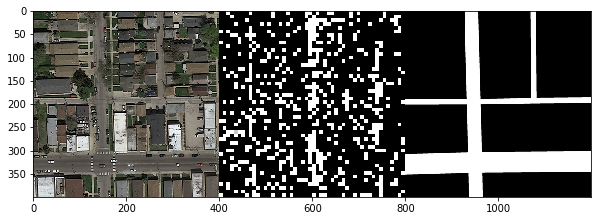

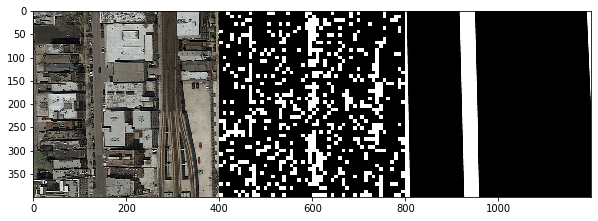

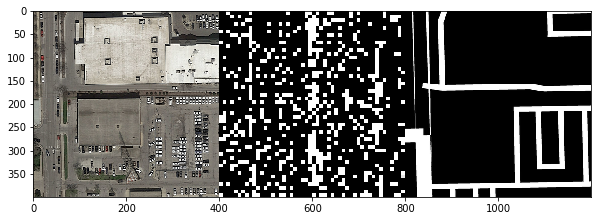

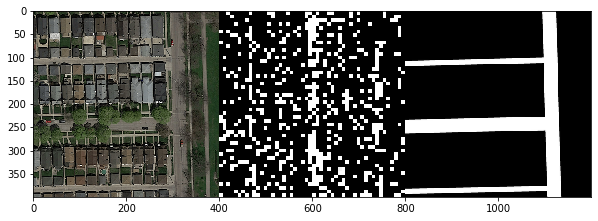

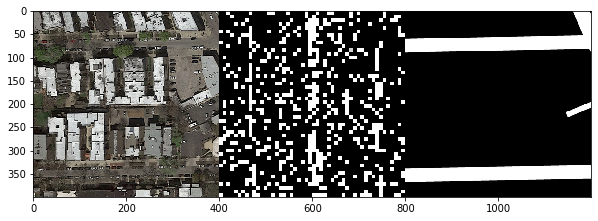

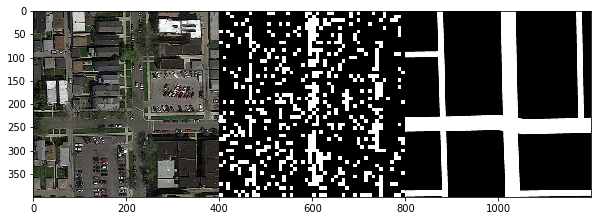

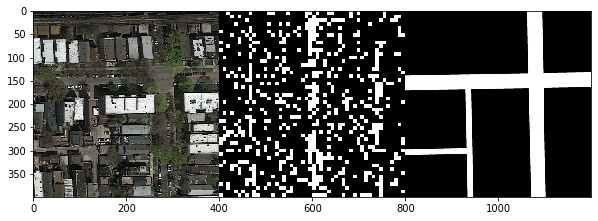

In [57]:
for i in range(20):
    visualize(i)